🔧 **Setup Required**: Before running this notebook, please follow the [setup instructions](../../README.md#setup-instructions) to configure your environment and API keys.

# Introduction to LangGraph: Learning about State

## Overview
This notebook introduces **LangGraph**, a library for building stateful, multi-actor applications with Language Models. LangGraph extends LangChain with the ability to create cyclic graphs, which are essential for developing sophisticated agent-based systems.

## What is LangGraph?
LangGraph allows you to define workflows as graphs where:
- **Nodes** represent computational steps (e.g., calling an LLM, running a tool)
- **Edges** define the flow between nodes
- **State** is maintained and updated as the graph executes

This paradigm is particularly powerful for building agents that need to make decisions, use tools, and maintain context across multiple steps.

## Learning Objectives
By the end of this notebook, you will understand:
1. How to define a state schema using `MessagesState`
2. How to create nodes (computational functions)
3. How to build a graph by adding nodes and edges
4. How to compile and execute a LangGraph application
5. The basic structure of a LangGraph workflow

## Step 0: Import Required Libraries

We begin by importing the essential components from LangGraph:
- **`StateGraph`**: The main class for creating graph-based workflows
- **`MessagesState`**: A built-in state schema optimized for conversational applications
- **`START` and `END`**: Special constants representing entry and exit points of the graph

In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END

## Step 1: Define the State Schema

**What is State?**
In LangGraph, the state is the data structure that flows through your graph. Each node can read from and write to the state.

**MessagesState Explained:**
`MessagesState` is a pre-built state schema that includes:
- A `messages` field that automatically accumulates messages using the `add_messages` reducer
- Built-in logic for appending new messages to the conversation history
- Support for message updates by ID

**Extending MessagesState:**
By creating `MyState` that inherits from `MessagesState`, we:
- Inherit the built-in message handling
- Add custom fields for our application:
  - **`response_count`**: Tracks how many AI responses have been generated
    - Uses the `add` reducer from Python's `operator` module to increment the count
  - **`user_name`**: Stores the user's name for personalization
    - Simple string field (no reducer means it will be overwritten)

**Understanding Reducers:**
Reducers determine how state updates are applied:
- **`add_messages`** (inherited): Appends new messages to the list, handles updates by ID
- **`operator.add`**: Adds numeric values together (perfect for counters like `response_count`)
- **No reducer** (user_name): The new value replaces the old value

In [2]:
# 1. Define the State
# MessagesState is a built-in state that appends messages
from typing import Annotated
from operator import add

class MyState(MessagesState):
    # Track how many times the AI has responded
    response_count: Annotated[int, add]
    # Store the user's name (optional field)
    user_name: str

## Step 2: Define Node Functions

**What is a Node?**
A node is a Python function that:
1. Takes the current state as input
2. Performs some computation (e.g., calls an LLM, retrieves data, processes information)
3. Returns updates to apply to the state

**Understanding the Node Function:**
- **Input**: The function receives the current `state` (of type `MyState`)
- **Reading State**: We use `state.get()` to safely access fields:
  - `user_name`: Retrieved with a default value of "there" if not set
  - `response_count`: Used to create a numbered greeting
- **Processing**: We create a personalized greeting using the state data
- **Output**: We return a dictionary with updates:
  - `messages`: A new AI message (appended to the conversation)
  - `response_count`: Set to 1 (will be added to the existing count due to the `add` reducer)

**Message Format:**
Messages are tuples of `(role, content)` where role can be:
- `"user"`: Messages from the human user
- `"ai"` or `"assistant"`: Messages from the AI
- `"system"`: System-level instructions

**State Updates:**
When you return a dictionary from a node:
- Fields with reducers (like `response_count` with `add`) combine values
- Fields without reducers (like `user_name`) replace the old value
- `messages` automatically appends to the list

In [3]:
# 2. Define the Nodes
def my_node(state: MyState):
    # Access the user_name from state
    user_name = state.get("user_name", "there")
    
    # Create a personalized greeting
    greeting = f"Hello {user_name}, welcome to LangGraph! This is response #{state.get('response_count', 0) + 1}."
    
    # Return updates to the state
    return {
        "messages": [("ai", greeting)],
        "response_count": 1  # This will be added to the existing count
    }

## Step 3-5: Build the Graph

Now we construct our workflow by defining the graph structure:

### Step 3: Initialize the Graph
`StateGraph(MyState)` creates a new graph that will use our state schema.

### Step 4: Add Nodes
`add_node(name, function)` registers our node function with a name that we can reference.

### Step 5: Add Edges
Edges define the flow of execution:
- **`add_edge(START, "my_node")`**: Defines that execution begins at `my_node`
  - `START` is a special constant representing the entry point
- **`add_edge("my_node", END)`**: Defines that after `my_node` executes, the graph terminates
  - `END` is a special constant representing the exit point

**Graph Structure:**
```
START → my_node → END
```

This creates a simple linear flow, but LangGraph supports complex branching and cycles!

In [4]:
# 3. Define the Graph
workflow = StateGraph(MyState)
# 4. Add Nodes
workflow.add_node("my_node", my_node)
# 5. Add Edges
workflow.add_edge(START, "my_node") # Entry point
workflow.add_edge("my_node", END)   # Exit point

## Step 6: Compile the Graph

**What does `compile()` do?**
The `compile()` method:
1. Validates the graph structure (ensures all nodes are connected properly)
2. Optimizes the execution plan
3. Creates a runnable application that can process inputs

**The Result:**
`app` is now a `CompiledStateGraph` - a ready-to-execute application that you can invoke with input data.

In [5]:
# 6. Compile
app = workflow.compile()


## Visualize the Graph

LangGraph can generate a visual representation of your workflow. This is extremely helpful for:
- Understanding complex graphs with multiple nodes and branches
- Debugging workflow issues
- Documenting your agent architecture

The visualization shows:
- **Nodes** as boxes (our `my_node`)
- **Edges** as arrows showing the flow of execution
- **START** and **END** points clearly marked

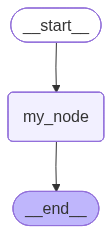

In [6]:
app

## Execute the Graph

Now let's run our application!

**How to invoke:**
Call `app.invoke()` with an initial state. In this case, we provide:
- **`messages`**: A list with one tuple `("user", "hi!")` representing the user's greeting
- **`user_name`**: Set to "Alice" to personalize the response
- **`response_count`**: Initialize to 0 (will be incremented by the node)

**What happens during execution:**
1. The graph starts at the START node
2. Flow moves to `my_node` (as defined by our edge)
3. `my_node` executes:
   - Reads `user_name` from the state ("Alice")
   - Reads `response_count` from the state (0)
   - Creates a personalized greeting
   - Returns updates:
     - Appends the AI message to `messages`
     - Adds 1 to `response_count` (making it 1)
4. Flow moves to END
5. The final state is returned

**Expected Output:**
You'll see the complete final state including:
- **messages**: Both the user message and AI's personalized response
- **response_count**: Updated to 1
- **user_name**: Still "Alice"

Try running it multiple times or with different names to see how the state updates!

In [7]:
# Run it
app.invoke({
    "messages": [("user", "hi!")],
    "user_name": "Alice",
    "response_count": 0
})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='611db68c-c0a9-490b-813e-1aa8047ff012'),
  AIMessage(content='Hello Alice, welcome to LangGraph! This is response #1.', additional_kwargs={}, response_metadata={}, id='9f87d4a5-fe47-4d4f-9fa2-874ef66bbf4b')],
 'response_count': 1,
 'user_name': 'Alice'}

## Understanding the State Object in LangGraph 1.0

In this example, we've defined a proper state object that extends `MessagesState`:

```python
from operator import add

class MyState(MessagesState):
    response_count: Annotated[int, add]
    user_name: str
```

**Why This Is Better Than Just `pass`:**

1. **Type Safety**: Each field has a defined type, making the code more robust
2. **Custom Business Logic**: We can track application-specific data (user name, response count)
3. **Flexible Reducers**: Different fields can have different update behaviors
4. **Extensibility**: Easy to add more fields as your application grows

**Common LangGraph 1.0 State Patterns:**

- **Counters**: Use `Annotated[int, operator.add]` for incrementing values
- **Lists**: Use `Annotated[list, operator.add]` to append items
- **Flags**: Use `bool` for simple on/off states
- **Context**: Use `str` or `dict` for configuration or context that gets replaced
- **Messages**: Inherit from `MessagesState` for conversation tracking

## Example: Running the Graph Multiple Times

Let's demonstrate how the state evolves with multiple invocations:

In [8]:
# First invocation
result1 = app.invoke({
    "messages": [("user", "hi!")],
    "user_name": "Alice",
    "response_count": 0
})

print("First invocation:")
print(f"Messages: {result1['messages']}")
print(f"Response count: {result1['response_count']}")
print(f"User name: {result1['user_name']}")
print("\n" + "="*50 + "\n")

# Second invocation - building on the previous state
result2 = app.invoke({
    "messages": result1['messages'] + [("user", "tell me more")],
    "user_name": "Alice",
    "response_count": result1['response_count']
})

print("Second invocation:")
print(f"Messages: {result2['messages']}")
print(f"Response count: {result2['response_count']}")
print(f"User name: {result2['user_name']}")

First invocation:
Messages: [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='2d136158-f95c-4baf-af73-411c0a00fac1'), AIMessage(content='Hello Alice, welcome to LangGraph! This is response #1.', additional_kwargs={}, response_metadata={}, id='a4e0ef69-efa5-4859-b345-86b543ef4dcc')]
Response count: 1
User name: Alice


Second invocation:
Messages: [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='2d136158-f95c-4baf-af73-411c0a00fac1'), AIMessage(content='Hello Alice, welcome to LangGraph! This is response #1.', additional_kwargs={}, response_metadata={}, id='a4e0ef69-efa5-4859-b345-86b543ef4dcc'), HumanMessage(content='tell me more', additional_kwargs={}, response_metadata={}, id='373220c2-c35a-40ec-b936-ca540b03fa46'), AIMessage(content='Hello Alice, welcome to LangGraph! This is response #2.', additional_kwargs={}, response_metadata={}, id='5bc6d24b-64eb-4cb8-af19-d0d795256bf1')]
Response count: 2
User name: Alice


**Observations:**

1. **Message Accumulation**: Each invocation adds new messages to the list
2. **Counter Increment**: The `response_count` increases by 1 with each node execution (due to the `add` reducer)
3. **Name Persistence**: The `user_name` remains "Alice" throughout
4. **Stateless Execution**: Each `invoke()` call is independent - we manually pass the previous state to maintain continuity

**Note on Statefulness:**
For truly stateful conversations that persist across invocations, LangGraph supports **checkpointers** which automatically save and restore state. This example shows manual state management for educational purposes.

### Example: Running Multiple Times

Let's see how the `response_count` accumulates by running the graph with an existing state:

## Key Takeaways and Next Steps

### What We've Learned
1. **LangGraph Basics**: How to create stateful workflows using graphs
2. **State Design**: How to extend `MessagesState` with custom fields and reducers
3. **State Management**: Using different reducer types (`add_messages`, `operator.add`, and simple replacement)
4. **Graph Components**: Nodes (computational units) and edges (flow control)
5. **Workflow Creation**: The complete process from definition to execution

### State Design Best Practices (LangGraph 1.0)
- **Start with MessagesState**: For conversational applications, inherit from `MessagesState`
- **Choose Appropriate Reducers**:
  - `operator.add` for counters and numeric accumulation (also works for lists and strings)
  - `operator.mul`, `operator.or_`, etc. for other operations
  - No reducer for values that should be replaced
- **Type Annotations**: Always use type hints for clarity and IDE support
- **Keep It Simple**: Start with essential fields, add more as needed


### Advanced Patterns
- **Human-in-the-loop**: Add breakpoints for human review and input
- **Parallel execution**: Run multiple nodes simultaneously
- **Subgraphs**: Compose complex workflows from smaller graph components
- **Checkpointing**: Save and restore graph state for long-running processes
- **State validation**: Use Pydantic models for type checking and validation

## Additional Resources

### Alternative State Definitions

LangGraph 1.0 supports multiple ways to define state:

**1. TypedDict (Used in this notebook)**
```python
from typing_extensions import TypedDict
from typing import Annotated
from operator import add
from langgraph.graph import MessagesState

class MyState(MessagesState):
    response_count: Annotated[int, add]
    user_name: str
```

**2. Pydantic BaseModel**
```python
from pydantic import BaseModel, Field
from typing import Annotated
from operator import add
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages

class MyStatePydantic(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field(default_factory=list)
    response_count: Annotated[int, add] = 0
    user_name: str = "Guest"
```

**3. Dataclass**
```python
from dataclasses import dataclass, field
from typing import Annotated
from operator import add
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages

@dataclass
class MyStateDataclass:
    messages: Annotated[list[AnyMessage], add_messages] = field(default_factory=list)
    response_count: Annotated[int, add] = 0
    user_name: str = "Guest"
```

Each approach has its benefits - choose based on your project's needs!

### Common Reducer Patterns

**From `operator` module (for standard operations):**
- `operator.add` - Addition (numbers, lists, strings)
- `operator.mul` - Multiplication
- `operator.or_` - Logical OR for boolean values

**From LangGraph:**
- `add_messages` - Special reducer for message lists (handles updates by ID)